The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


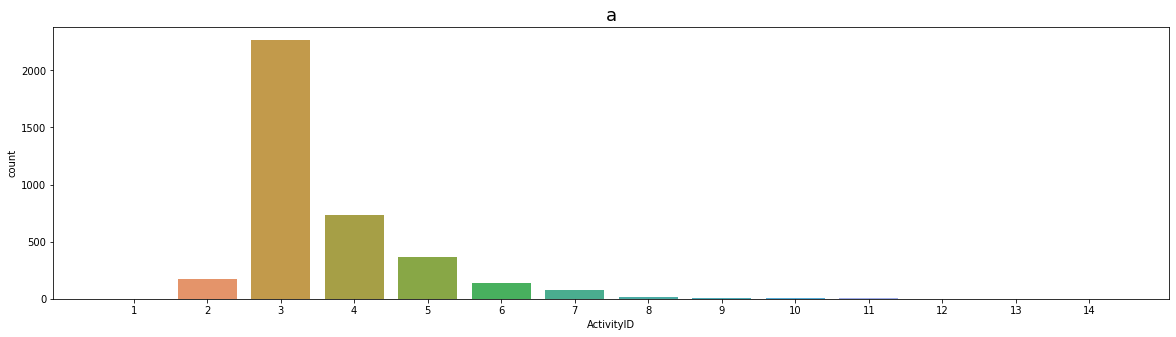

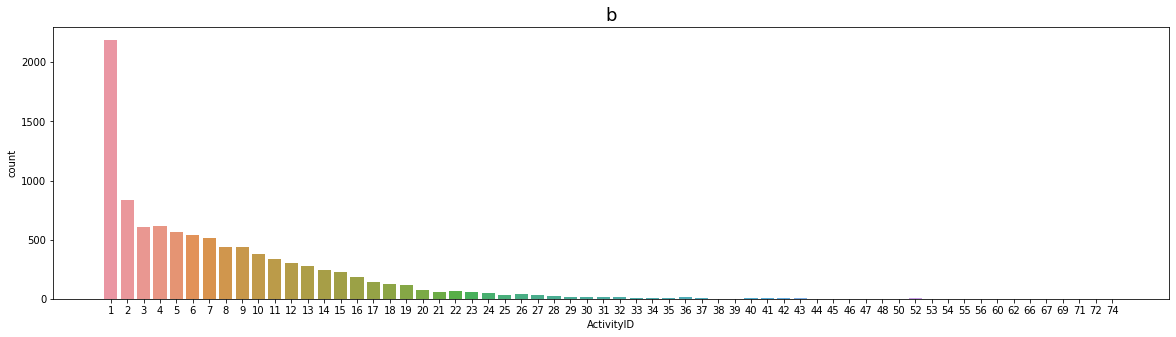

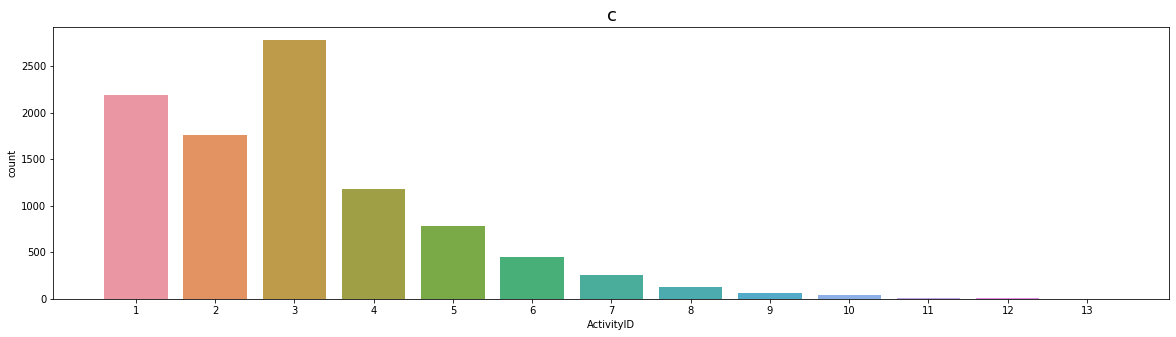

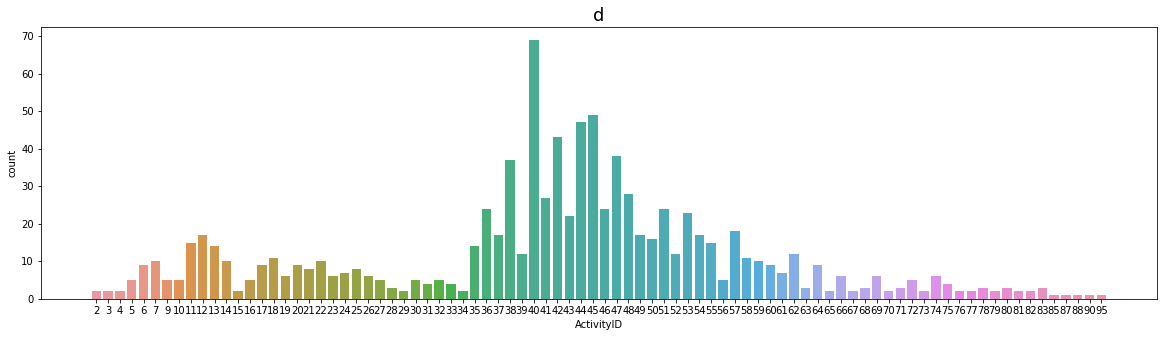

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from t2e_utils import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
palette=sns.color_palette("RdBu_r", 50)
import pickle
import random
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Dense,LSTM,GRU,Activation,Masking,BatchNormalization,Lambda,Input
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import RMSprop,Adam,Nadam
from tensorflow.keras.callbacks import History, EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import wtte.wtte as wtte
import os
plt.style.use('seaborn-muted')
# # np.random.seed(2)
# # pd.set_option("display.max_rows",1000)
%matplotlib inline
%load_ext autoreload
%autoreload 2
import h5py
import timeit

path = '../Tax_paper/data/'
a = os.path.join(path,'helpdesk.csv')
b = os.path.join(path,'bpi_12_w.csv')
c = os.path.join(path,'bpi_12_w_no_repeat.csv')
d = os.path.join(path,'env_permit.csv')

a = pd.read_csv(a)
b = pd.read_csv(b)
c = pd.read_csv(c)
d = pd.read_csv(d)

df_dict = {
    'a': a,
    'b': b,
    'c': c,
    'd':d
}
range_dict = {
    'a': range(2,8,1),
    'b': range(2,22,2),
    'c': range(2,12,2),
    'd': range(2,22,2)
}

for key, dataset in df_dict.items():
#     if key == 'b':
    plt.figure(figsize=(20,5))
    sns.countplot(dataset.groupby(["CaseID"]).agg({"ActivityID":'count'})["ActivityID"])
    plt.title(key,fontsize=18)
    plt.plot()

In [51]:
# baseline = {}
# for dataset in ['b']:
#     tmp = df_dict[dataset].groupby(["Prefix length"]).apply(lambda x:mean_absolute_error(x['Ground truth times'], x['Predicted times'])/86400).to_dict()
#     tmp = {k:v for k,v in tmp.items() if k in list(range_dict[dataset])}
#     baseline[dataset] = list(tmp.values())
# pickle.dump(baseline, open("baseline.pkl","wb"))

In [201]:
dataset='b'
res='s'
censored=True
cen_per=0.4
fit_type:'t2e'
df_results = dict()
suffix = 12

# for suffix in range_dict[dataset]:

print("\ndataset:", dataset, "\tSuffix:", suffix)
t2e_obj = t2e(df_dict[dataset], 
              suffix = suffix, 
              resolution = res, 
              censored = censored , 
              cen_prc = cen_per)
dataset_preprocessed = t2e_obj.preprocess()
X_train, X_test, X_val, y_train, y_test, y_val, len_train, len_val, len_test = t2e_obj.smart_split(train_prc = 0.7,
                                                                                                     val_prc = 0.45,
                                                                                                     scaling=True)


dataset: b 	Suffix: 12
all cases 1896
first 10 censored cases [178774 176590 202479 180034 200341 196398 178474 174710 177764 213624]
	Total Observed: 1138
	Training data Observed: 438
	Training data Censored: 758
	Training data to use: 1196
	Validation data: 358
	Testing data   : 342


In [2]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

NameError: name 'X_train' is not defined

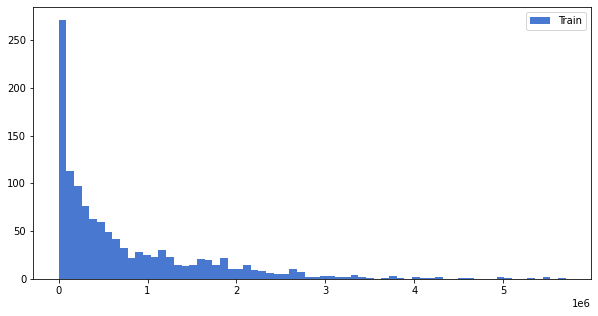

In [204]:
if res == 'd':
    bins = np.arange(0,y_train.max()+1, 1)
elif res == 'h':
    bins = np.arange(0,y_train.max()+24, 24)
elif res == 's':
    bins = np.arange(0,y_train.max()+86400, 86400)
    
plt.figure(figsize=(10,5))
plt.hist(y_train[:,0], bins = bins,label="Train");
# plt.hist(y_val[:,0], bins = bins,label="Val");
# plt.hist(y_test[:,0], bins = bins, label="Test");

plt.legend()
plt.show()

0.5 2.0


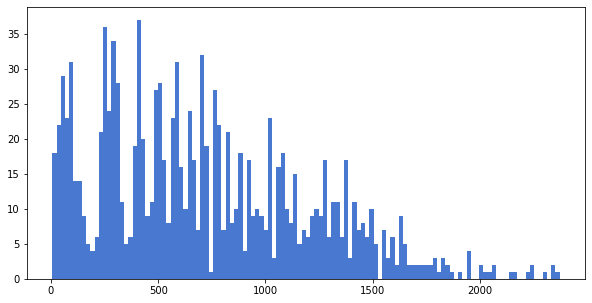

In [208]:
root = 2


root = 1/root
power = 1/root
print(root, power)

plt.figure(figsize=(10,5))
y_conv = (y_train[:,0]**root)
plt.hist(y_conv, bins = 120,label="Train");

In [3]:
print("Layer size:",4, end = " ..... ")
t2e_obj.fit(X_train, y_train**root, X_val, y_val**root,size=4, vb = True)
print("Done")
print("Training accomplished in", t2e_obj.fit_time, "seconds")
test_result_df, mae, accuracy = t2e_obj.evaluate(X_test,y_test)
len(test_result_df['T_pred'].unique())

Layer size: 4 ..... 

NameError: name 't2e_obj' is not defined

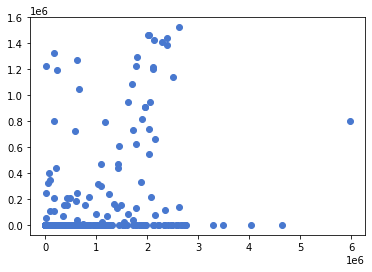

In [207]:
y_pred = test_result_df['T_pred']
plt.scatter(x=y_test[:,0], y=y_pred**power)

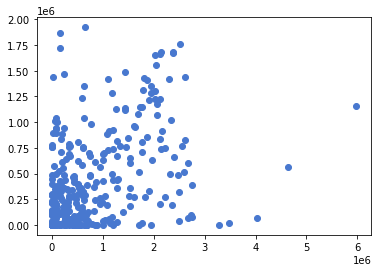

In [210]:
y_pred = test_result_df['T_pred']
plt.scatter(x=y_test[:,0], y=y_pred**power)

## Model

NameError: name 'X_train' is not defined

39.61 %
6.9187372332806625


0.000000         131
572305.327135      1
467776.547960      1
12362.481203       1
119622.915000      1
530607.497940      1
1560.363417        1
541080.010155      1
54530.127458       1
249221.351949      1
638682.537682      1
509132.108079      1
60081.856340       1
260528.370095      1
533129.787514      1
112213.378451      1
426978.794381      1
619108.943794      1
161197.221725      1
19014.184437       1
513833.880994      1
24191.968839       1
100676.861572      1
2056.424726        1
Name: predicted_mode, dtype: int64

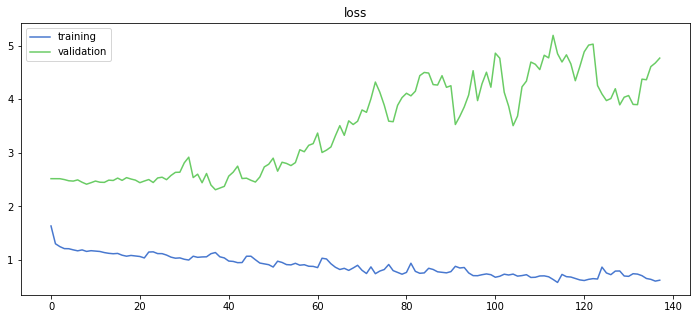

In [21]:
# model.load_weights(test_out_path + 'best_model.h5')
history = pd.read_csv(test_out_path + 'training.log', sep=',', engine='python')

test_result_df, mae, accuracy = evaluating(X_test,y_test, model, resolution = res)
print(accuracy, "%")
print(mae)

plt.figure(figsize = (12,5));
plt.plot(history['loss'], label='training');
plt.plot(history['val_loss'],label='validation');
plt.title('loss');
plt.legend();
test_result_df["predicted_mode"].value_counts()

###############################################################################################################################

No handles with labels found to put in legend.


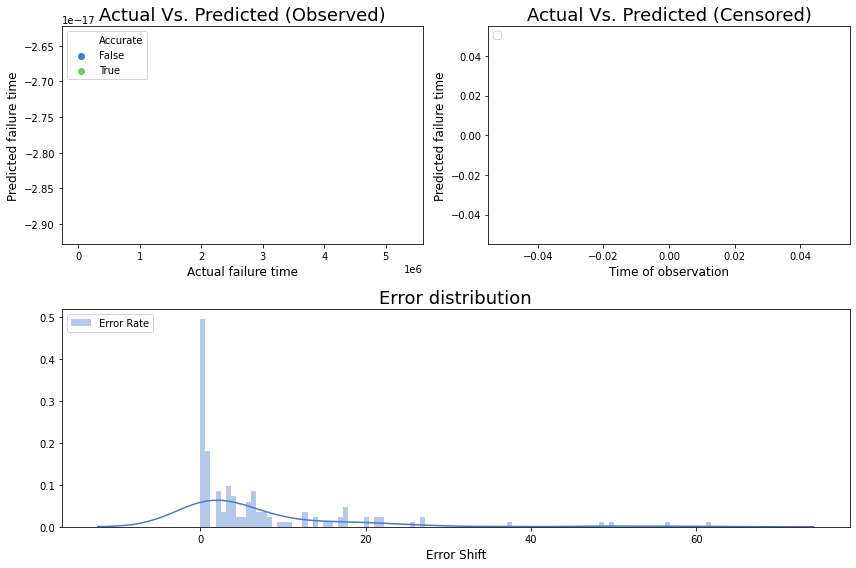

In [56]:
plot_predictions_insights(test_result_df);

14.931 %
8.443295953557465


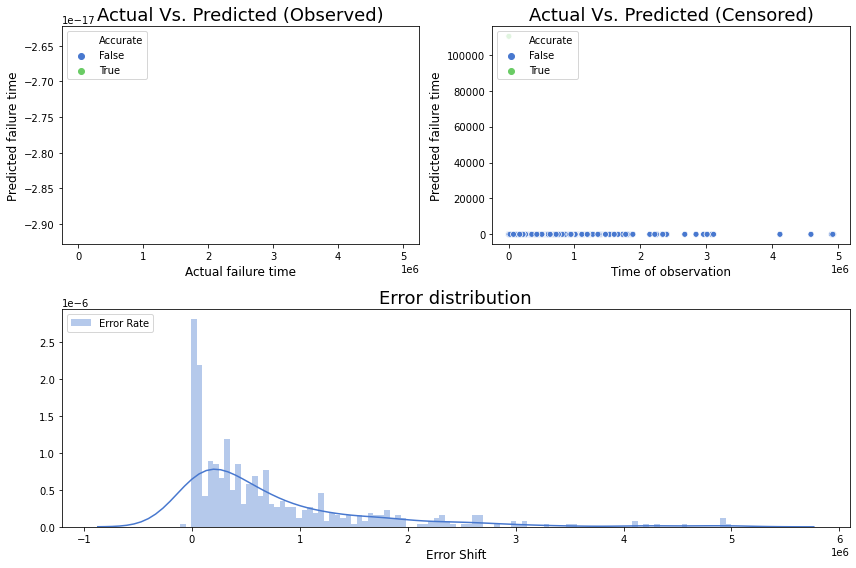

In [78]:
test_result_df, mae, accuracy = evaluating(X_train,y_train, model,resolution='s')
print(accuracy, "%")
print(mae)
plot_predictions_insights(test_result_df)

In [15]:
# plot_top_predictions(test_result_df,15,top_feature="T",ascending=False, U=1,accurate=True)

In [1]:
######################################################################################
censored   = True
cen_prc = 0.4
res = "s"
key = "a"
maes_path = 'output_files/maes/'

if censored == False:
    filename = "observed_"+str(cen_prc)+"_"+res+".pkl"
    model_path = 'output_files/models/observed/'
else:
    filename = "censored_"+str(cen_prc)+"_"+res+".pkl"
    ## model_path stores the model weights and history training
    model_path = 'output_files/models/censored_new/'
######################################################################################
mae_list=[]
res_list=[]
print("dataset:",key)
for suffix in range_dict[key]:
    print("\tsuffix:",suffix)
    print("\t\tpreprocessing", end =" ...... ")
    dataset_preprocessed = preprocess(df_dict[key], 
                                      min_length = suffix,
                                      censored   = censored,  
                                      cen_prc    = cen_prc)
    print("done")
    print("\t\tsuffix splitting", end = " ... ")
    X_train, X_test, X_val, y_train, y_test, y_val = smart_split(dataset_preprocessed, 
                                                                 train_perc = 0.70,
                                                                 val_perc   = 0.3,
                                                                 suffix     = suffix,
                                                                 resolution = res,
                                                                 scaling    = True)
    print("done")
    print("\t\t\tTraining   shape:",X_train.shape, y_train.shape)
    print("\t\t\tValidation shape:",X_val.shape, y_val.shape)
    print("\t\t\tTesting    shape:",X_test.shape, y_test.shape)
    print("\t\tTraining", end =" ........... ")
    model = train(X_train, y_train, X_val, y_val, suffix, model_path)
    print("done")
    result_df, mae,accuracy = evaluating(X_test,y_test,model,resolution=res)
    print("\t\t\tMAE:",mae)
    print("\t\t\tAcc:",accuracy, "%")
    mae_list.append(mae)
    res_list.append(result_df)   
pickle.dump(res_list, open(model_path + "ResultDF_" + filename,"wb"))
pickle.dump(mae_list, open(maes_path + filename,"wb"))

dataset: b


NameError: name 'range_dict' is not defined

In [21]:
# case = 'censored_50_s.pkl'
# pickle.load(open(case, "rb"))
# pickle.dump(pickle.load(open(case, "rb"))["b"], open("baseline_practical.pkl", "wb"))

suffix =  2
0    169
Name: predicted_mode, dtype: int64


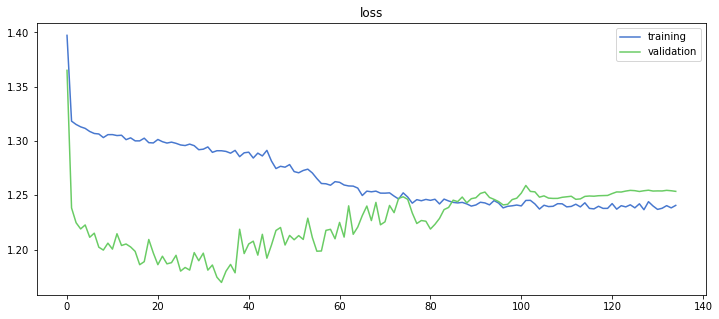

suffix =  4
0.000000e+00    1182
1.741215e+06       2
2.364516e+04       2
1.868519e+06       2
8.910431e+05       2
                ... 
1.741147e+06       1
2.520153e+04       1
4.115759e+05       1
7.065964e+05       1
4.255752e+05       1
Name: predicted_mode, Length: 998, dtype: int64


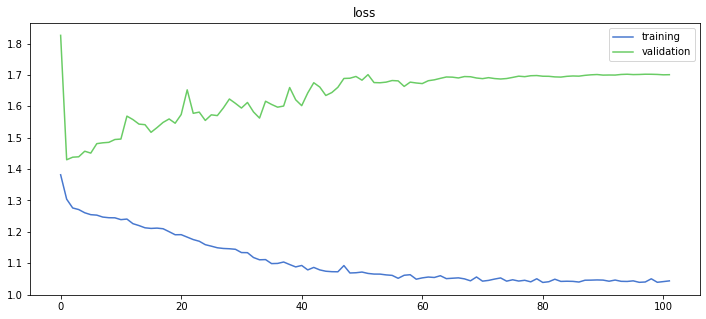

suffix =  6
0.000000e+00    611
1.073432e+06      1
6.191441e+05      1
6.452086e+05      1
9.425883e+05      1
               ... 
8.576436e+05      1
8.805231e+05      1
1.750781e+05      1
2.859706e+05      1
2.710367e+05      1
Name: predicted_mode, Length: 1176, dtype: int64


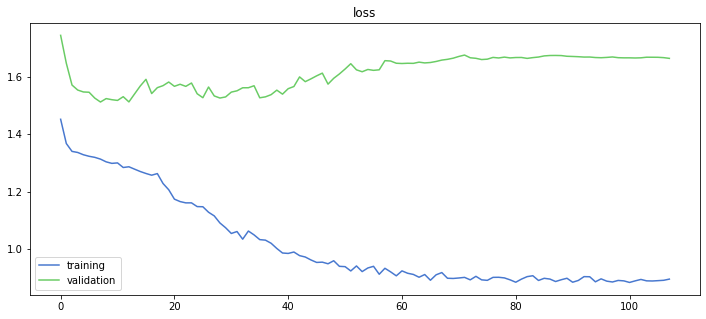

suffix =  8
0.000000         925
785752.803089      1
44348.823020       1
627945.053045      1
82253.877583       1
                ... 
162204.330407      1
239448.137450      1
679493.029762      1
121687.973684      1
330235.515064      1
Name: predicted_mode, Length: 498, dtype: int64


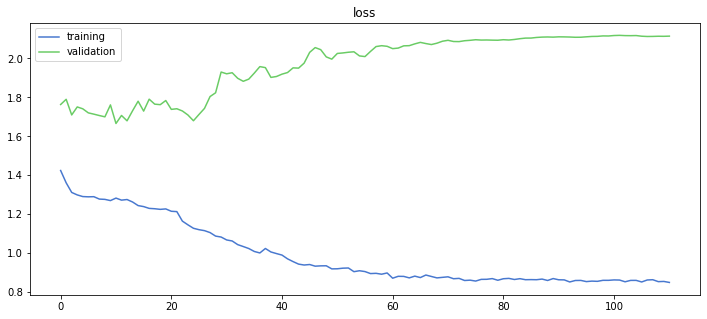

suffix =  10
0.000000         745
856324.693754      1
160319.873996      1
251398.437894      1
20179.496452       1
                ... 
598092.723099      1
384890.596426      1
114044.481878      1
230634.009559      1
189306.042088      1
Name: predicted_mode, Length: 363, dtype: int64


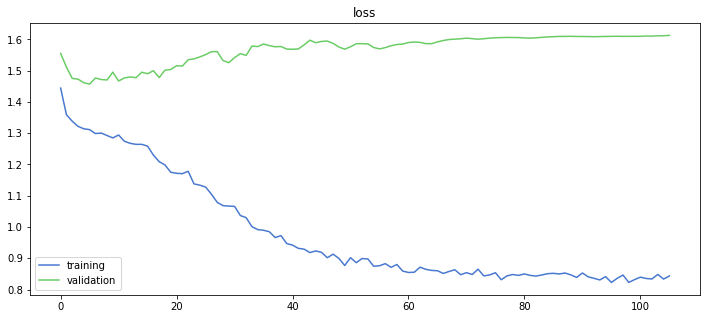

suffix =  12
0.000000         440
454062.033222      1
402509.613628      1
184840.193864      1
833001.261374      1
                ... 
332967.767150      1
345251.652739      1
283409.503159      1
58081.434991       1
320062.475252      1
Name: predicted_mode, Length: 398, dtype: int64


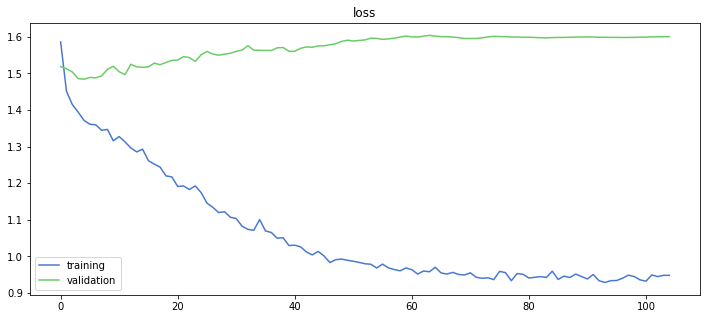

suffix =  14
0.000000e+00    425
1.146298e+06      1
7.284861e+05      1
2.272860e+04      1
1.019189e+06      1
               ... 
5.970553e+05      1
1.001580e+06      1
7.795295e+04      1
1.149717e+06      1
2.003721e+05      1
Name: predicted_mode, Length: 202, dtype: int64


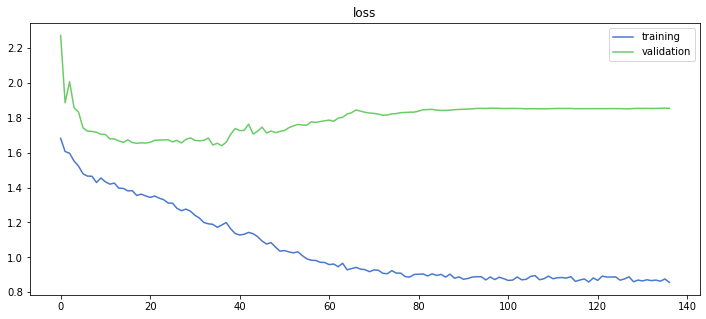

suffix =  16
0.000000e+00    250
1.861694e+04      1
8.478032e+05      1
1.222259e+03      1
1.122859e+06      1
               ... 
8.379701e+05      1
1.456961e+05      1
3.172219e+05      1
5.414739e+05      1
3.251906e+05      1
Name: predicted_mode, Length: 204, dtype: int64


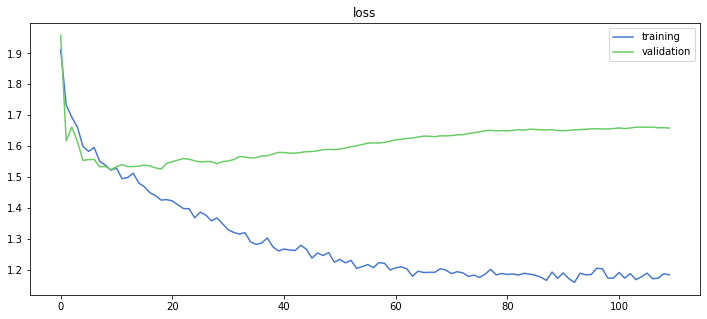

suffix =  18
0.000000         246
194438.850453      1
620067.631355      1
391827.725208      1
89908.593333       1
                ... 
44177.587447       1
190419.989236      1
26462.392961       1
386403.014423      1
22975.678320       1
Name: predicted_mode, Length: 71, dtype: int64


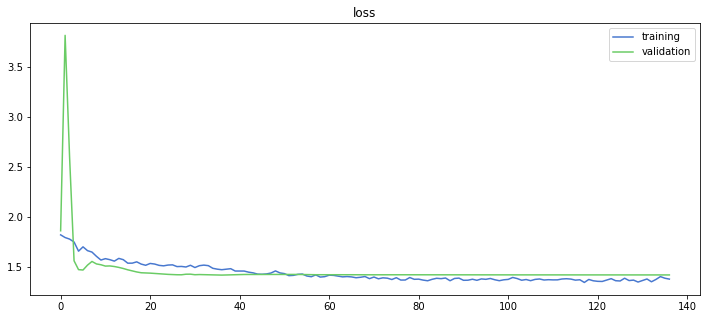

suffix =  20
0    231
Name: predicted_mode, dtype: int64


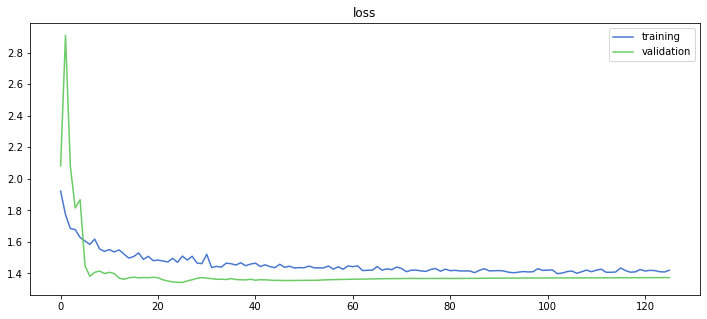

In [33]:
for i, suffix in enumerate(range_dict[dataset]):

    print("suffix = ", suffix)
    print(test_result_df["predicted_mode"].value_counts())
    history = pd.read_csv(path +'training_'+str(suffix)+'.log', sep=',', engine='python')
    test_result_df = pickle.load(open(path+"test_res_censored_50_s.pkl", "rb"))[i]
    plt.figure(figsize = (12,5));
    plt.plot(history['loss'], label='training');
    plt.plot(history['val_loss'],label='validation');
    plt.title('loss');
    plt.legend();
    plt.show();
    print("============================================================================")

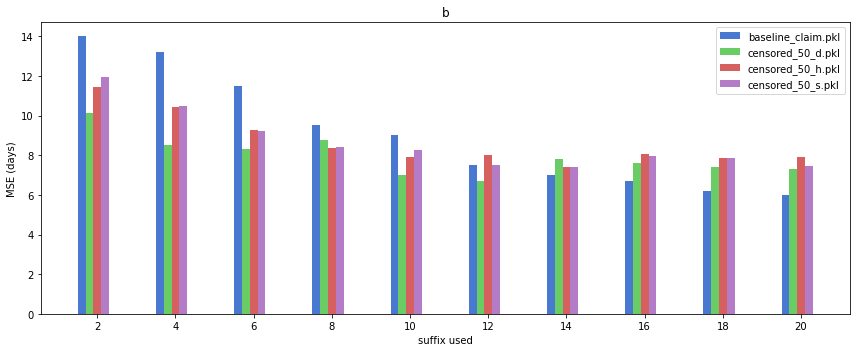

In [27]:
cases = ["baseline_claim.pkl", "observed_40_s.pkl", "censored_50_h.pkl", "censored_50_s.pkl"]

fig, ax = plt.subplots(1, 1, figsize=(12,5))

for i,dataset in enumerate(['b']):

    X = np.array(range_dict[dataset])
    steps = [-0.4, -0.2, 0, 0.2]
    for j,case in enumerate(cases):
        data = pickle.load(open(maes_path + case,"rb"));
        plt.bar(X+steps[j], data, width = 0.2, label=case);
    
    plt.xticks(range_dict[dataset])
    plt.legend();
    plt.xlabel("suffix used")
    plt.ylabel("MSE (days)")
    plt.title(dataset)
plt.tight_layout()
plt.show()

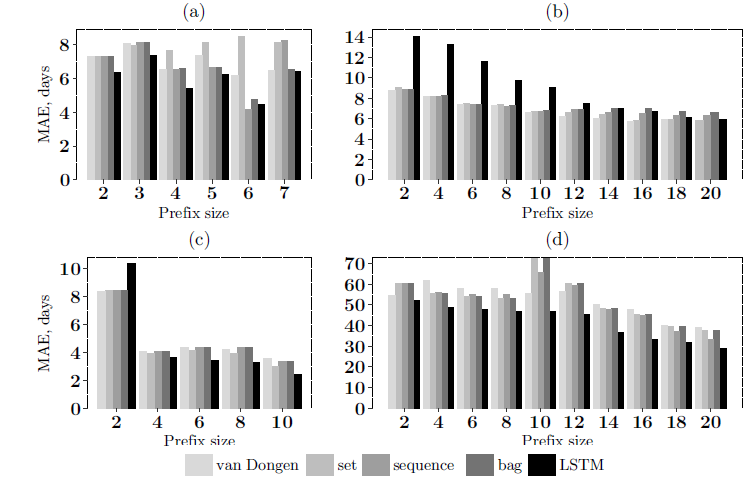